In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm
import xml.dom.minidom

import pandas as pd
import os 
from glob import glob

import numpy as np
import cv2

import PIL
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

In [3]:
import sys

sys.path.append('..')
from src.utils.xml_parser import parse_xml
from src.configs import config

%load_ext autoreload
%autoreload 2

In [4]:
paths = glob(os.path.join(config.PATHS.CSV, 'export_gr-mri-spine*.csv'))
paths

['../data/descr/export_gr-mri-spine-11.csv',
 '../data/descr/export_gr-mri-spine-8.csv',
 '../data/descr/export_gr-mri-spine-13.csv',
 '../data/descr/export_gr-mri-spine-9.csv',
 '../data/descr/export_gr-mri-spine-5.csv',
 '../data/descr/export_gr-mri-spine-3.csv',
 '../data/descr/export_gr-mri-spine-1.csv',
 '../data/descr/export_gr-mri-spine-10.csv',
 '../data/descr/export_gr-mri-spine-4.csv',
 '../data/descr/export_gr-mri-spine-12.csv',
 '../data/descr/export_gr-mri-spine-7.csv',
 '../data/descr/export_gr-mri-spine-2.csv']

In [5]:
dfs = list()
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)
dfs = pd.concat(dfs)
dfs['Файлы'] = dfs['Файлы'].apply(lambda x: x.split('/n')[0])

dfs.head()

,ID,Исследователь,Кейс,Файлы,Протокол,XML,Файлы разметки,На срезе визуализируются межпозвоночные диски,Шейный межпозвоночный диск - здоровый,Шейный межпозвоночный диск - с подозрением на патологию,Шейный межпозвоночный диск - патологический,грудной межпозвоночный диск - здоровый,грудной межпозвоночный диск - с подозрением на паталогию,грудной межпозвоночный диск - патологический,поясничный межпозвоночный диск - здоровый,поясничный межпозвоночный диск - с подозрением на патологию,поясничный межпозвоночный диск - патологический,крестцовый межпозвоночный диск - здоровый,крестцовый межпозвоночный диск - с подозрением на патологию,крестцовый межпозвоночный диск - патологический
0,3483,Ilya Gusev,5576 - dcm-dromanov,img_01010.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Не визуализируются (срез не пригоден для разме...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3111,Ilya Gusev,5577 - dcm-dromanov,img_01047.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3484,Ilya Gusev,5578 - dcm-dromanov,img_01096.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3108,Ilya Gusev,5579 - dcm-dromanov,img_01023.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3109,Ilya Gusev,5580 - dcm-dromanov,img_01089.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dfs['На срезе визуализируются межпозвоночные диски'].value_counts()

Не визуализируются (срез не пригоден для разметки)    531
Визуализируются (можно размечать)                     365
Name: На срезе визуализируются межпозвоночные диски, dtype: int64

In [7]:
print(
    dfs['Протокол'].value_counts(),
    dfs['Исследователь'].value_counts()
)

MRI_NECK_SAG_prot_hern    916
Name: Протокол, dtype: int64 Ruslan Panasenko    401
Ilya Gusev          301
Denis Shpak         214
Name: Исследователь, dtype: int64


In [8]:
columns_annot = [
    'Файлы разметки',
    'Шейный межпозвоночный диск - здоровый',
    'Шейный межпозвоночный диск - с подозрением на патологию',
    'Шейный межпозвоночный диск - патологический',
    'грудной межпозвоночный диск - здоровый',
    'грудной межпозвоночный диск - с подозрением на паталогию',
    'грудной межпозвоночный диск - патологический',
    'поясничный межпозвоночный диск - здоровый',
    'поясничный межпозвоночный диск - с подозрением на патологию',
    'поясничный межпозвоночный диск - патологический',
    'крестцовый межпозвоночный диск - здоровый',
    'крестцовый межпозвоночный диск - с подозрением на патологию',
    'крестцовый межпозвоночный диск - патологический'
]
labels = dfs[columns_annot]
labels.isna().sum()

Файлы разметки                                                 916
Шейный межпозвоночный диск - здоровый                          916
Шейный межпозвоночный диск - с подозрением на патологию        916
Шейный межпозвоночный диск - патологический                    916
грудной межпозвоночный диск - здоровый                         916
грудной межпозвоночный диск - с подозрением на паталогию       916
грудной межпозвоночный диск - патологический                   916
поясничный межпозвоночный диск - здоровый                      916
поясничный межпозвоночный диск - с подозрением на патологию    916
поясничный межпозвоночный диск - патологический                916
крестцовый межпозвоночный диск - здоровый                      916
крестцовый межпозвоночный диск - с подозрением на патологию    916
крестцовый межпозвоночный диск - патологический                916
dtype: int64

### Drop unused columns:

In [9]:
dfs = dfs.drop(['Исследователь', 'Протокол'] + columns_annot, axis=1)
dfs.head()

,ID,Кейс,Файлы,XML,На срезе визуализируются межпозвоночные диски
0,3483,5576 - dcm-dromanov,img_01010.jpg,<annotation>\r\n <filename>https://...,Не визуализируются (срез не пригоден для разме...
1,3111,5577 - dcm-dromanov,img_01047.jpg,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать)
2,3484,5578 - dcm-dromanov,img_01096.jpg,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать)
3,3108,5579 - dcm-dromanov,img_01023.jpg,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать)
4,3109,5580 - dcm-dromanov,img_01089.jpg,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать)


In [10]:
datas = list()
for i, row in tqdm(dfs.iterrows()):
    if pd.isna(row.XML):
        continue
    visual = row['На срезе визуализируются межпозвоночные диски']
    if pd.isna(visual) or 'Не визуализируются' in visual:
        continue
    data = parse_xml(row)
    datas.append(data)

916it [00:00, 1280.49it/s]


In [11]:
datas = pd.concat(datas, sort=False, ignore_index=True)
datas.head()

,coords,name,occluded,id,filename,case
0,161 103 202 103 202 126 161 126,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov
1,161 132 204 132 204 154 161 154,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov
2,161 163 210 163 210 181 161 181,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov
3,161 185 214 185 214 201 161 201,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov
4,165 209 219 209 219 227 165 227,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov


In [12]:
dom = xml.dom.minidom.parseString(row.XML)
print(dom.toprettyxml())

<?xml version="1.0" ?>
<annotation>
	
            
	<filename>https://label.dev.dsai.io/storage/app/uploads/public/5b7/eb9/219/5b7eb921963b8270155397.jpg</filename>
	
            
	<imagesize>
		
              
		<nrows>384</nrows>
		
              
		<ncols>384</ncols>
		
            
	</imagesize>
	
          
</annotation>



### No occlusion has been found:

In [13]:
datas.occluded.value_counts()

no    2681
Name: occluded, dtype: int64

In [14]:
datas.name.value_counts()

shejnyj-mezhpozvonochnyj-disk-zdorovyj                       958
grudnoj-mezhpozvonochnyj-disk-zdorovyj                       912
shejnyj-mezhpozvonochnyj-disk-patologicheskij                401
shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu    330
grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu     52
grudnoj-mezhpozvonochnyj-disk-patologicheskij                 26
hernia                                                         1
protrusion                                                     1
Name: name, dtype: int64

In [15]:
datas['is_normal'] = datas.name.apply(lambda x: 'disk-zdorovyj' in x)
datas['type'] = datas.name.apply(lambda x: 'chest' if 'grudnoj' in x else 'neck')
datas.head()

,coords,name,occluded,id,filename,case,is_normal,type
0,161 103 202 103 202 126 161 126,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov,True,neck
1,161 132 204 132 204 154 161 154,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov,True,neck
2,161 163 210 163 210 181 161 181,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov,True,neck
3,161 185 214 185 214 201 161 201,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov,True,neck
4,165 209 219 209 219 227 165 227,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3111,img_01047.jpg,5577 - dcm-dromanov,True,neck


In [16]:
datas.type.value_counts()

neck     1691
chest     990
Name: type, dtype: int64

In [17]:
key = 'hernia'
datas.query('name==@key')

,coords,name,occluded,id,filename,case,is_normal,type
1937,179 210 231 210 231 230 179 230,hernia,no,3459,img_01187.jpg,5709 - dcm-dromanov,False,neck


In [18]:
inuse_columns = ['coords', 'name', 'id', 'filename', 'is_normal', 'type']
path = os.path.join(config.PATHS.CSV, 'labels.csv')
datas[inuse_columns].to_csv(path, index=False)
pd.read_csv(path).head()

,coords,name,id,filename,is_normal,type
0,161 103 202 103 202 126 161 126,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck
1,161 132 204 132 204 154 161 154,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck
2,161 163 210 163 210 181 161 181,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck
3,161 185 214 185 214 201 161 201,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck
4,165 209 219 209 219 227 165 227,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck


### There're some safe duplicates in orginal descr files:

In [23]:
duplicates = dfs['Файлы'].value_counts()[:12]
print(duplicates)
key = np.random.choice(duplicates.index.tolist())
dfs.query('Файлы==@key')

img_00427.jpg    7
img_00234.jpg    6
img_00200.jpg    5
img_00299.jpg    3
img_00264.jpg    3
img_00365.jpg    2
img_00259.jpg    2
img_01181.jpg    2
img_00246.jpg    2
img_00407.jpg    2
img_00276.jpg    2
img_01292.jpg    1
Name: Файлы, dtype: int64


,ID,Кейс,Файлы,XML,На срезе визуализируются межпозвоночные диски
31,5591,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
32,5592,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
33,5593,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
34,5594,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
35,5595,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
36,5596,5060 - dcm-dromanov,img_00427.jpg,NaN,Не визуализируются (срез не пригоден для разме...
37,5597,5060 - dcm-dromanov,img_00427.jpg,<annotationgroup><annotation>\r\n ...,Не визуализируются (срез не пригоден для разме...


# Check ramdom annotation

In [24]:
ids = datas.id.unique()
key = np.random.choice(ids)
data = datas.query('id==@key')
data

,coords,name,occluded,id,filename,case,is_normal,type
1933,173 107 212 107 212 134 173 134,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3459,img_01187.jpg,5709 - dcm-dromanov,True,neck
1934,169 139 206 139 206 160 169 160,shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,3459,img_01187.jpg,5709 - dcm-dromanov,True,neck
1935,169 165 213 165 213 185 169 185,shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na...,no,3459,img_01187.jpg,5709 - dcm-dromanov,False,neck
1936,170 185 217 185 217 207 170 207,protrusion,no,3459,img_01187.jpg,5709 - dcm-dromanov,False,neck
1937,179 210 231 210 231 230 179 230,hernia,no,3459,img_01187.jpg,5709 - dcm-dromanov,False,neck
1938,187 233 234 233 234 255 187 255,grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na...,no,3459,img_01187.jpg,5709 - dcm-dromanov,False,chest
1939,196 258 255 258 255 277 196 277,grudnoj-mezhpozvonochnyj-disk-zdorovyj,no,3459,img_01187.jpg,5709 - dcm-dromanov,True,chest
1940,215 283 266 283 266 303 215 303,grudnoj-mezhpozvonochnyj-disk-zdorovyj,no,3459,img_01187.jpg,5709 - dcm-dromanov,True,chest


In [25]:
polygons = data.coords.values
polygons = [list(map(int, poly.split(' '))) for poly in polygons]
polygons = np.array(polygons)
shape = polygons.shape
polygons = polygons.reshape(shape[0], shape[1] // 2, 2)

In [26]:
img = cv2.imread(os.path.join(config.PATHS.IMAGES, data.filename.values[0]))
image = PIL.Image.fromarray(img)
draw = PIL.ImageDraw.Draw(image)

colours = {
    True: (255, 255, 255),
    False: (255, 150, 150),
}
for poly, cond in zip(polygons, data.is_normal):
    draw.polygon(([tuple(pair) for pair in poly]), outline=colours[cond])

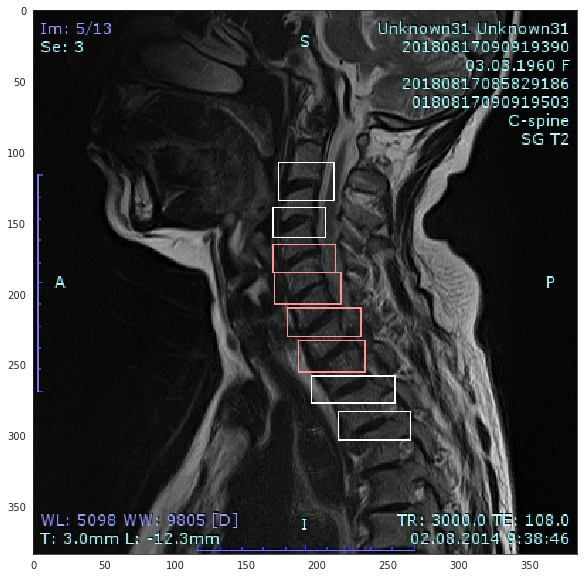

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(image)